# **Training an Testing**

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib

In [14]:
def load_data_files():

    base_dir = os.path.abspath(os.path.dirname(__file__)) if '__file__' in globals() else os.getcwd()

    data_dir = os.path.join(base_dir, 'Processed Data')

    X_train_path = os.path.join(data_dir, 'X_train_processed.npy')
    y_train_path = os.path.join(data_dir, 'y_train_processed.npy')
    X_test_path = os.path.join(data_dir, 'X_test_processed.npy')
    y_test_path = os.path.join(data_dir, 'y_test_processed.npy')

    X_train_mx = np.load(X_train_path, allow_pickle = True).item()
    y_train_mx = np.load(y_train_path, allow_pickle = True)
    X_test_mx = np.load(X_test_path, allow_pickle = True).item()
    y_test_mx = np.load(y_test_path, allow_pickle = True)

    X_train = pd.DataFrame(X_train_mx.toarray())
    y_train = pd.Series(y_train_mx.ravel())
    X_test = pd.DataFrame(X_test_mx.toarray())
    y_test = pd.Series(y_test_mx.ravel())

    return X_train, y_train, X_test, y_test

In [15]:
# Call the function

X_train, y_train, X_test, y_test = load_data_files()

In [16]:
def load_column_names():

    base_dir = os.path.abspath(os.path.dirname(__file__)) if '__file__' in globals() else os.getcwd()

    data_dir = os.path.join(base_dir, 'Processing Objects')

    column_names_path = os.path.join(data_dir, 'the_preprocessor.joblib')

    column_names_pre = joblib.load(column_names_path)

    column_names = column_names_pre.get_feature_names_out()

    return column_names

In [17]:
# Call the function

column_names = load_column_names()

In [18]:
# Match the name with the corresponding column

X_train.columns = column_names
X_test.columns = column_names

In [19]:
print(column_names.tolist())

['numerical__Age', 'numerical__EducationLevel', 'numerical__BMI', 'numerical__CognitiveTestScore', 'binary_categorical__Gender_Male', 'binary_categorical__Diabetes_Yes', 'binary_categorical__Hypertension_Yes', 'binary_categorical__CholesterolLevel_Normal', 'binary_categorical__AlzheimerInFamily_Yes', 'binary_categorical__GeneticRisk_Yes', 'binary_categorical__UrbanRural_Urban', 'multi_binary_categorical__Country_Argentina', 'multi_binary_categorical__Country_Australia', 'multi_binary_categorical__Country_Brazil', 'multi_binary_categorical__Country_Canada', 'multi_binary_categorical__Country_China', 'multi_binary_categorical__Country_France', 'multi_binary_categorical__Country_Germany', 'multi_binary_categorical__Country_India', 'multi_binary_categorical__Country_Italy', 'multi_binary_categorical__Country_Japan', 'multi_binary_categorical__Country_Mexico', 'multi_binary_categorical__Country_Norway', 'multi_binary_categorical__Country_Russia', 'multi_binary_categorical__Country_Saudi Ara

# **Hyperparameter Tuning**

In [20]:
import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score

In [21]:
# Stratified Cross Validation

cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

In [22]:
# Dictionary to save the results

model_results = {}

In [ ]:
# Hyperparameter Tuning with Optuna (Objective Functions)



# XGBoost

# Personalized Wrapping, to ensure that XGBoost Classifier behaves like a Sklearn method

from sklearn.base import BaseEstimator, ClassifierMixin
from xgboost import XGBClassifier

class SklearnXGBClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, **kwargs):

        self.model = XGBClassifier(**kwargs)

    def fit(self, X, y):

        self.model.fit(X, y)

        return self

    def predict(self, X):
        
        return self.model.predict(X)

    def predict_proba(self, X):
        
        return self.model.predict_proba(X)

    def get_params(self, deep = True):
        
        return self.model.get_params(deep)

    def set_params(self, **params):
        
        self.model.set_params(**params)
        
        return self



def xgb_objective(trial):
    
    model = SklearnXGBClassifier(
        n_estimators = trial.suggest_int('n_estimators', 50, 150),
        max_depth = trial.suggest_int('max_depth', 5, 15),
        learning_rate = trial.suggest_float('learning_rate', 1e-2, 1e-1, log = True),
        subsample = trial.suggest_float('subsample', 0.5, 1.0),
        eval_metric = 'logloss',random_state = 42,n_jobs = -1
    )

    return cross_val_score(model, X_train, y_train, cv = cv, scoring = 'accuracy').mean()



# Stacking

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

def stacking_objective(trial):

    estimators = [
        ('rf', RandomForestClassifier(n_estimators = 50, random_state = 42)),
        ('dt', DecisionTreeClassifier(min_samples_leaf = 2, random_state = 42)),
        ('gbc', GradientBoostingClassifier(n_estimators = 50, random_state = 42))
    ]

    meta_estimator = LogisticRegression(
        C = trial.suggest_float('C', 1e-2, 10.0, log = True),
        max_iter = 1000,
        random_state = 42
    )

    model = StackingClassifier(
        estimators = estimators,
        final_estimator = meta_estimator,
        passthrough = trial.suggest_categorical('passthrough', [True, False]),
        n_jobs = -1
    )

    return cross_val_score(model, X_train, y_train, cv = cv, scoring = 'accuracy').mean()



# Random Forest

from sklearn.ensemble import RandomForestClassifier

def rf_objective(trial):

    model = RandomForestClassifier(
        n_estimators = trial.suggest_int('n_estimators', 50, 100),
        max_depth = trial.suggest_int('max_depth', 15, 50),
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10),
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10),
        random_state = 42, n_jobs = -1
    )

    return cross_val_score(model, X_train, y_train, cv = cv, scoring = 'accuracy').mean()


# LightGBM

from lightgbm import LGBMClassifier

def lgbm_objective(trial):
    
    model = LGBMClassifier(
        n_estimators = trial.suggest_int('n_estimators', 50, 150),
        max_depth = trial.suggest_int('max_depth', 3, 15),
        learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-1, log = True),
        num_leaves = trial.suggest_int('num_leaves', 20, 100),
        subsample = trial.suggest_float('subsample', 0.5, 1.0),
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0),
        random_state = 42, n_jobs=-1, verbosity = -1
    )

    return cross_val_score(model, X_train, y_train, cv = cv, scoring = 'accuracy').mean()



# KNN

from sklearn.neighbors import KNeighborsClassifier

def knn_objective(trial):

    model = KNeighborsClassifier(
        n_neighbors = trial.suggest_int('n_neighbors', 3, 8),
        metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])
    )

    return cross_val_score(model, X_train, y_train, cv = cv, scoring = 'accuracy').mean()


# Decision Tree

from sklearn.tree import DecisionTreeClassifier

def dt_objective(trial):

    model = DecisionTreeClassifier(
        max_depth = trial.suggest_int('max_depth', 3, 12),
        min_samples_split = trial.suggest_int('min_samples_split', 2, 7),
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 7),
        criterion = trial.suggest_categorical('criterion', ['gini', 'entropy']), 
        random_state = 42
    )

    return cross_val_score(model, X_train, y_train, cv = cv, scoring = 'accuracy').mean()


# Multi-Layer Perceptron

from sklearn.neural_network import MLPClassifier

def mlp_objective(trial):

    model = MLPClassifier(
        hidden_layer_sizes = (trial.suggest_int('hl1', 10, 40),
                              trial.suggest_int('hl2', 10, 50)),
        activation = trial.suggest_categorical('activation', ['relu', 'tanh']),
        alpha = trial.suggest_float('alpha', 1e-3, 1e-1, log = True),
        learning_rate = trial.suggest_categorical('learning_rate', ['constant', 'adaptive']),
        learning_rate_init = trial.suggest_float('learning_rate_init', 1e-4, 1e-1, log = True),
        max_iter = 500, random_state = 42
        
    )

    return cross_val_score(model, X_train, y_train, cv = cv, scoring = 'accuracy').mean()


# Gradient Boost Classifier

from sklearn.ensemble import GradientBoostingClassifier

def gbc_objective(trial):
    
    model = GradientBoostingClassifier(
        n_estimators = trial.suggest_int('n_estimators', 50, 150),
        learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-1, log = True),
        max_depth = trial.suggest_int('max_depth', 3, 10),
        subsample = trial.suggest_float('subsample', 0.5, 1.0),
        random_state = 42
    )

    return cross_val_score(model, X_train, y_train, cv = cv, scoring = 'accuracy').mean()



# Support Vector Machine (SVM)

from sklearn.svm import SVC

def svm_objective(trial):

    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'sigmoid'])
    gamma = trial.suggest_float('gamma', 1e-4, 1e-1, log = True)
    model = SVC(kernel = kernel, gamma = gamma, probability = True)

    return cross_val_score(model, X_train, y_train, cv = cv, scoring = 'accuracy').mean()


In [24]:
# Execute the tuning and save the models as tuples

models = {
    'LightGBM': (lgbm_objective, LGBMClassifier),
    'XGBoost': (xgb_objective, XGBClassifier),
    'Stacking': (stacking_objective, StackingClassifier),
    'Random Forest': (rf_objective, RandomForestClassifier),
    'KNN': (knn_objective, KNeighborsClassifier),
    'Decision Tree': (dt_objective, DecisionTreeClassifier),
    'MLP': (mlp_objective, MLPClassifier),
    'Gradient Boosting': (gbc_objective, GradientBoostingClassifier),
    'SVM': (svm_objective, SVC),
}


for name, (objective, constructor) in models.items():

    print("Optimizating", name, " ...")
    print("------------------------------------------------------------------------------------------------")
    print("------------------------------------------------------------------------------------------------")

    study = optuna.create_study(direction = 'maximize')
    study.optimize(objective, n_trials = 10)

    print("Best accuracy: ", study.best_value)
    print("Hyperparameters: ", study.best_params)

    
    # Train the model with the best hyperparameter fit

    if name == 'MLP':
        params = study.best_params.copy()
        hl1 = params.pop('hl1')
        hl2 = params.pop('hl2')
        final_model = constructor(
            hidden_layer_sizes = (hl1, hl2),
            **params
        )

    elif name == 'Stacking':
        params = study.best_params.copy()
        passthrough = params.pop('passthrough')
        C = params.pop('C')

        estimators = [
            ('rf', RandomForestClassifier(n_estimators = 50, random_state = 42)),
            ('dt', DecisionTreeClassifier(min_samples_leaf = 2, random_state = 42)),
            ('gbc', GradientBoostingClassifier(n_estimators = 50, random_state = 42))
        ]

        final_model = StackingClassifier(
            estimators = estimators,
            final_estimator = LogisticRegression(C = C, max_iter = 1000, random_state = 42),
            passthrough = passthrough, n_jobs = -1
        )

    else:
        final_model = constructor(**study.best_params)


    # Fit the model

    final_model.fit(X_train, y_train)

    # Evaluate on test set

    y_pred = final_model.predict(X_test)
    acc_metric = accuracy_score(y_test, y_pred)

    print("Accuracy in test: ", acc_metric)

    # Save results

    model_results[name] = {
        'accuracy_test': acc_metric,
        'model': final_model,
        'parameters': study.best_params,
        'study': study
    }

[I 2025-06-17 11:46:13,148] A new study created in memory with name: no-name-a2746b18-ed60-4aa5-a0a7-8197eba6c2b1


Optimizating LightGBM  ...
------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------


[I 2025-06-17 11:46:16,415] Trial 0 finished with value: 0.7072194663688076 and parameters: {'n_estimators': 116, 'max_depth': 13, 'learning_rate': 0.010643877203710038, 'num_leaves': 72, 'subsample': 0.7066337035847874, 'colsample_bytree': 0.7031257684047441}. Best is trial 0 with value: 0.7072194663688076.
[I 2025-06-17 11:46:18,079] Trial 1 finished with value: 0.7204892371307892 and parameters: {'n_estimators': 131, 'max_depth': 5, 'learning_rate': 0.030128576176060066, 'num_leaves': 58, 'subsample': 0.949786071242218, 'colsample_bytree': 0.8922775142023589}. Best is trial 1 with value: 0.7204892371307892.
[I 2025-06-17 11:46:18,773] Trial 2 finished with value: 0.6076387781369511 and parameters: {'n_estimators': 80, 'max_depth': 3, 'learning_rate': 0.0031133302428775636, 'num_leaves': 26, 'subsample': 0.6532210406120806, 'colsample_bytree': 0.9768889730661925}. Best is trial 1 with value: 0.7204892371307892.
[I 2025-06-17 11:46:19,608] Trial 3 finished with value: 0.72179698121860

Best accuracy:  0.7217969812186084
Hyperparameters:  {'n_estimators': 131, 'max_depth': 3, 'learning_rate': 0.09867066541086178, 'num_leaves': 44, 'subsample': 0.5329032825641946, 'colsample_bytree': 0.5109418476113343}


[I 2025-06-17 11:46:26,658] A new study created in memory with name: no-name-27a01f9e-aa43-4447-aeb5-eb2971dd913b


Accuracy in test:  0.7221449405429661
Optimizating XGBoost  ...
------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------


[I 2025-06-17 11:46:31,302] Trial 0 finished with value: 0.7043732625918173 and parameters: {'n_estimators': 56, 'max_depth': 15, 'learning_rate': 0.017071387077126386, 'subsample': 0.6333763560424628}. Best is trial 0 with value: 0.7043732625918173.
[I 2025-06-17 11:46:32,837] Trial 1 finished with value: 0.7195853817304918 and parameters: {'n_estimators': 133, 'max_depth': 5, 'learning_rate': 0.011249505482921878, 'subsample': 0.5457303155167652}. Best is trial 1 with value: 0.7195853817304918.
[I 2025-06-17 11:46:39,068] Trial 2 finished with value: 0.709719667941444 and parameters: {'n_estimators': 84, 'max_depth': 14, 'learning_rate': 0.01672942833529301, 'subsample': 0.7335677476583053}. Best is trial 1 with value: 0.7195853817304918.
[I 2025-06-17 11:46:40,012] Trial 3 finished with value: 0.703680919762995 and parameters: {'n_estimators': 69, 'max_depth': 5, 'learning_rate': 0.01226830470283383, 'subsample': 0.7717140089301568}. Best is trial 1 with value: 0.7195853817304918.
[

Best accuracy:  0.7195853817304918
Hyperparameters:  {'n_estimators': 133, 'max_depth': 5, 'learning_rate': 0.011249505482921878, 'subsample': 0.5457303155167652}


[I 2025-06-17 11:47:04,513] A new study created in memory with name: no-name-ab8be9c3-a453-4769-b587-7d9fa9ab97ae


Accuracy in test:  0.7207987435494727
Optimizating Stacking  ...
------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------


[I 2025-06-17 11:48:30,420] Trial 0 finished with value: 0.7206430832846353 and parameters: {'C': 4.193485461385948, 'passthrough': False}. Best is trial 0 with value: 0.7206430832846353.
[I 2025-06-17 11:49:49,036] Trial 1 finished with value: 0.7191430555452817 and parameters: {'C': 0.05071084084341889, 'passthrough': True}. Best is trial 0 with value: 0.7206430832846353.
[I 2025-06-17 11:51:03,088] Trial 2 finished with value: 0.7204892648701428 and parameters: {'C': 0.04845238950484598, 'passthrough': False}. Best is trial 0 with value: 0.7206430832846353.
[I 2025-06-17 11:52:16,954] Trial 3 finished with value: 0.7207007885373594 and parameters: {'C': 0.1308652951770435, 'passthrough': False}. Best is trial 3 with value: 0.7207007885373594.
[I 2025-06-17 11:53:35,538] Trial 4 finished with value: 0.7206046772248811 and parameters: {'C': 0.11190896666998035, 'passthrough': True}. Best is trial 3 with value: 0.7207007885373594.
[I 2025-06-17 11:54:55,539] Trial 5 finished with value

Best accuracy:  0.7208546457869469
Hyperparameters:  {'C': 0.6755970383033681, 'passthrough': False}


[I 2025-06-17 12:00:34,974] A new study created in memory with name: no-name-5d5b9664-5671-492c-8af1-232fc928d68c


Accuracy in test:  0.7196769127215615
Optimizating Random Forest  ...
------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------


[I 2025-06-17 12:00:39,326] Trial 0 finished with value: 0.7117966538942354 and parameters: {'n_estimators': 75, 'max_depth': 39, 'min_samples_leaf': 1, 'min_samples_split': 5}. Best is trial 0 with value: 0.7117966538942354.
[I 2025-06-17 12:00:42,604] Trial 1 finished with value: 0.7157391113790528 and parameters: {'n_estimators': 63, 'max_depth': 18, 'min_samples_leaf': 4, 'min_samples_split': 6}. Best is trial 1 with value: 0.7157391113790528.
[I 2025-06-17 12:00:45,670] Trial 2 finished with value: 0.7117967204686841 and parameters: {'n_estimators': 52, 'max_depth': 26, 'min_samples_leaf': 1, 'min_samples_split': 5}. Best is trial 1 with value: 0.7157391113790528.
[I 2025-06-17 12:00:50,296] Trial 3 finished with value: 0.7177391687070502 and parameters: {'n_estimators': 97, 'max_depth': 24, 'min_samples_leaf': 8, 'min_samples_split': 8}. Best is trial 3 with value: 0.7177391687070502.
[I 2025-06-17 12:00:53,142] Trial 4 finished with value: 0.7153351968014675 and parameters: {'n_

Best accuracy:  0.7177391687070502
Hyperparameters:  {'n_estimators': 97, 'max_depth': 24, 'min_samples_leaf': 8, 'min_samples_split': 8}


[I 2025-06-17 12:01:18,642] A new study created in memory with name: no-name-d6a80983-178e-4879-be42-eea8b4cada23


Accuracy in test:  0.7185550818936505
Optimizating KNN  ...
------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------


[I 2025-06-17 12:01:22,920] Trial 0 finished with value: 0.6394092386841931 and parameters: {'n_neighbors': 6, 'metric': 'minkowski'}. Best is trial 0 with value: 0.6394092386841931.
[I 2025-06-17 12:01:27,084] Trial 1 finished with value: 0.6423901466117303 and parameters: {'n_neighbors': 5, 'metric': 'minkowski'}. Best is trial 1 with value: 0.6423901466117303.
[I 2025-06-17 12:01:46,533] Trial 2 finished with value: 0.619773841049805 and parameters: {'n_neighbors': 4, 'metric': 'manhattan'}. Best is trial 1 with value: 0.6423901466117303.
[I 2025-06-17 12:01:50,782] Trial 3 finished with value: 0.6481980312456079 and parameters: {'n_neighbors': 8, 'metric': 'euclidean'}. Best is trial 3 with value: 0.6481980312456079.
[I 2025-06-17 12:02:10,475] Trial 4 finished with value: 0.6347166702419612 and parameters: {'n_neighbors': 8, 'metric': 'manhattan'}. Best is trial 3 with value: 0.6481980312456079.
[I 2025-06-17 12:02:30,143] Trial 5 finished with value: 0.626158719033635 and paramet

Best accuracy:  0.6481980312456079
Hyperparameters:  {'n_neighbors': 8, 'metric': 'euclidean'}


[I 2025-06-17 12:02:48,918] A new study created in memory with name: no-name-15f58fd0-7df4-4b7b-b166-0f1b93bb6539


Accuracy in test:  0.6537581332735024
Optimizating Decision Tree  ...
------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------


[I 2025-06-17 12:02:49,804] Trial 0 finished with value: 0.7188930056144451 and parameters: {'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 6, 'criterion': 'entropy'}. Best is trial 0 with value: 0.7188930056144451.
[I 2025-06-17 12:02:50,893] Trial 1 finished with value: 0.7139312748267215 and parameters: {'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 6, 'criterion': 'entropy'}. Best is trial 0 with value: 0.7188930056144451.
[I 2025-06-17 12:02:52,095] Trial 2 finished with value: 0.7130658680198538 and parameters: {'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 3, 'criterion': 'entropy'}. Best is trial 0 with value: 0.7188930056144451.
[I 2025-06-17 12:02:52,734] Trial 3 finished with value: 0.7203161602077122 and parameters: {'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 5, 'criterion': 'gini'}. Best is trial 3 with value: 0.7203161602077122.
[I 2025-06-17 12:02:53,588] Trial 4 finished with value: 0.718719912047756 and paramete

Best accuracy:  0.7204315411245165
Hyperparameters:  {'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 4, 'criterion': 'gini'}
Accuracy in test:  0.7199012788871438
Optimizating MLP  ...
------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------


c:\Users\USUARIO\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\USUARIO\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
[I 2025-06-17 12:07:47,712] Trial 0 finished with value: 0.6639292757439694 and parameters: {'hl1': 36, 'hl2': 50, 'activation': 'tanh', 'alpha': 0.009800478381999171, 'learning_rate': 'adaptive', 'learning_rate_init': 0.000905307402605792}. Best is trial 0 with value: 0.6639292757439694.
[I 2025-06-17 12:08:13,800] Trial 1 finished with value: 0.7046423879515042 and parameters: {'hl1': 21, 'hl2': 43, 'activation': 'tanh', 'alpha': 0.003091993464675863, 'learning_rate

Best accuracy:  0.7118544571593423
Hyperparameters:  {'hl1': 24, 'hl2': 26, 'activation': 'relu', 'alpha': 0.0328281113871932, 'learning_rate': 'constant', 'learning_rate_init': 0.05063955044048914}


[I 2025-06-17 12:23:44,689] A new study created in memory with name: no-name-d30a9160-d65d-43b2-88eb-97a1241a7729


Accuracy in test:  0.7152344626430335
Optimizating Gradient Boosting  ...
------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------


[I 2025-06-17 12:24:14,100] Trial 0 finished with value: 0.5865417902608978 and parameters: {'n_estimators': 55, 'learning_rate': 0.0012249505348296075, 'max_depth': 6, 'subsample': 0.7108322765015573}. Best is trial 0 with value: 0.5865417902608978.
[I 2025-06-17 12:24:46,028] Trial 1 finished with value: 0.5865417902608978 and parameters: {'n_estimators': 59, 'learning_rate': 0.001384789817698933, 'max_depth': 6, 'subsample': 0.7402586879915636}. Best is trial 0 with value: 0.5865417902608978.
[I 2025-06-17 12:25:32,540] Trial 2 finished with value: 0.7203161472626807 and parameters: {'n_estimators': 133, 'learning_rate': 0.017722416290695236, 'max_depth': 3, 'subsample': 0.8710330565191053}. Best is trial 2 with value: 0.7203161472626807.
[I 2025-06-17 12:26:14,212] Trial 3 finished with value: 0.5865417902608978 and parameters: {'n_estimators': 50, 'learning_rate': 0.001383421713514515, 'max_depth': 8, 'subsample': 0.8662631339729905}. Best is trial 2 with value: 0.7203161472626807

Best accuracy:  0.7203161472626807
Hyperparameters:  {'n_estimators': 133, 'learning_rate': 0.017722416290695236, 'max_depth': 3, 'subsample': 0.8710330565191053}


[I 2025-06-17 12:34:14,844] A new study created in memory with name: no-name-0a592a49-b16c-4c31-8f3e-fa1497a19559


Accuracy in test:  0.7199461521202603
Optimizating SVM  ...
------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------


[I 2025-06-17 13:03:38,261] Trial 0 finished with value: 0.7126428095896794 and parameters: {'kernel': 'linear', 'gamma': 0.0013352444014453847}. Best is trial 0 with value: 0.7126428095896794.
[I 2025-06-17 13:33:50,011] Trial 1 finished with value: 0.7126428095896794 and parameters: {'kernel': 'linear', 'gamma': 0.0928752276724382}. Best is trial 0 with value: 0.7126428095896794.
[I 2025-06-17 13:45:18,129] Trial 2 finished with value: 0.7092003890906671 and parameters: {'kernel': 'rbf', 'gamma': 0.01799727470933265}. Best is trial 0 with value: 0.7126428095896794.
[I 2025-06-17 13:56:46,519] Trial 3 finished with value: 0.713969804788922 and parameters: {'kernel': 'rbf', 'gamma': 0.0020622454773098968}. Best is trial 3 with value: 0.713969804788922.
[I 2025-06-17 14:08:17,589] Trial 4 finished with value: 0.7087003983371183 and parameters: {'kernel': 'rbf', 'gamma': 0.0209961106581337}. Best is trial 3 with value: 0.713969804788922.
[I 2025-06-17 14:19:39,960] Trial 5 finished with 

Best accuracy:  0.713969804788922
Hyperparameters:  {'kernel': 'rbf', 'gamma': 0.0020622454773098968}
Accuracy in test:  0.7128113080547454


In [39]:
# Find the accuracy score for each model

print("\nAccuracy Score resume in test set:\n")

for name, result in model_results.items():
    accuracy = round(result['accuracy_test'], 4)
    print(name + ": Accuracy = " + str(accuracy))


Accuracy Score resume in test set:

LightGBM: Accuracy = 0.7221
XGBoost: Accuracy = 0.7208
Stacking: Accuracy = 0.7197
Random Forest: Accuracy = 0.7186
KNN: Accuracy = 0.6538
Decision Tree: Accuracy = 0.7199
MLP: Accuracy = 0.7152
Gradient Boosting: Accuracy = 0.7199
SVM: Accuracy = 0.7128


The results of evaluating the models are similar between them. All of the models could be put in the same tier but KNN which had a under-performance compared to them. In that section, those models with higher metric were the ensemble-based methods. The best models are clustered in a same range (roughly between 0.71 and 0.72), it indicates that some methods are performing marginally better, almost all are achieving similar results.

# **Graphic Report from Optuna**

In [50]:
import optuna.visualization as vis

In [62]:
# Optimization History Plot

for model_name, results in model_results.items():

    fig = vis.plot_optimization_history(results['study'])
    fig.update_layout(title = "Optimization History for " + str(model_name))
    fig.show()

It's evident in the grapics that the "optimal" values or the higher one were reached between the second and fourth trial, in the following attemps they appear to behave a bit more volatile and "random" but in values near the higher ones. The optimization history of the Stacking and LghtGBM should be highlighted due to their flatness and consistency throughout the repetitions. 
The models with higher accuracy and dispersion are XGBoost and SVM; the models with better precision and convergence in general throughout the trials were the tree-based ensemble model.

In [63]:
# Hyperparameters Importance

for model_name, results in model_results.items():

    fig = vis.plot_param_importances(results['study'])
    fig.update_layout(title = "Hyperparameter Importance for " + str(model_name))
    fig.show()

* **LightGBM:** the most important with huge difference was learning_rate followed by colsample_bytree and mid_child_sample. The picture is very telling, the learning rate dominates the model's behavior.
* **XGBoost:** just like the previous case, the learning_rate was dominant and vital for the performance, followed by the trees complexity (max_depth and colsample_bytree)
* **Stacking:** in this case, the most important element was the cross validation stage.
* **Random Forest:** min_sample_leaf, n_estimators and max_samples_split were the prominent hyperparameters. The control of the leaf size is key.
* **KNN:** As expected, the n_neighbors has the biggest impact in the model accuracy.
* **Decision Tree:** the depth of the tree is what defines the performance of the model.
* **MLP:** Against all odds, the regularization coefficient weights more than the network architecture.
* **Gradient Boosting:** the learning_rate is determinant for a good performance.
* **SVM:** the gamma parameter (support points influence) dominetes the model optimization.

In conclusion, the most critical parameter in boosting methods is the learning_rate. In the tree-based methods the most prominent parameters were the depth and the amunt of sample in each leaf. 

In [68]:
# Sensibility of each hyperparameter according to the metric

for model_name, results in model_results.items():

    fig = vis.plot_slice(results['study'])
    fig.update_layout(title = "Sensibility of hyperparameters in relation to the metric per trial for " + str(model_name))
    fig.show()

LightGBM shows a clear sensibility for the learning_rate, the values closd to 0.1 tend to be the optimal, also the depth shouldn't be high. The XGBoost method shows a sensibility for the larning_rate too and max_depth and subsample affect non-linearly the model performance. For the stacking model the regularization of the meta-model really impact, also the passthrough seems irrelevant. Controlling leaf depth and size is more important than increasing n_estimators for the Random Forest. For the Decision Treeit seems that medium levels of depth tend to perform better. And finally, the SVM demonstrate thta the typer of kernel has no importance, however the highr gamma values are.  

In [76]:
# Empirical Distribution Plot

for model_name, results in model_results.items():

    fig = vis.plot_edf(results['study'])
    fig.update_layout(title = "Empirical Distribution Plot for " + str(model_name))
    fig.show()

The LightGBM and Stacking are the most consistent and estable (vertical curves near the top); there are models with higher variance like SVM, MLP and Decision Tree; KNN is the worst model; the Random Forest and Gardient Boosting are a mix of consistency and performance

# **Different Metrics Analysis with Tuned Models**

In [40]:
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, roc_curve)

# Model 1: LightGBM

Clasification Report:

              precision    recall  f1-score   support

           0       0.77      0.75      0.76     13071
           1       0.66      0.68      0.67      9214

    accuracy                           0.72     22285
   macro avg       0.71      0.72      0.72     22285
weighted avg       0.72      0.72      0.72     22285



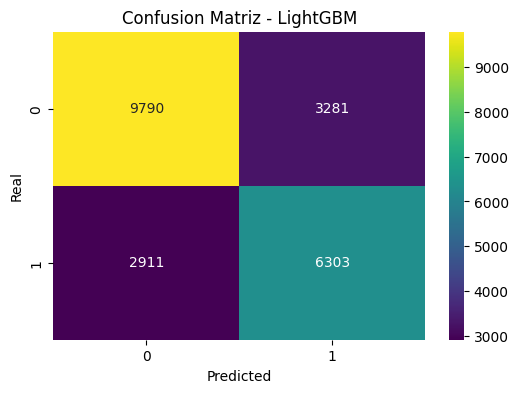

ROC AUC Score:  0.7962420707183755


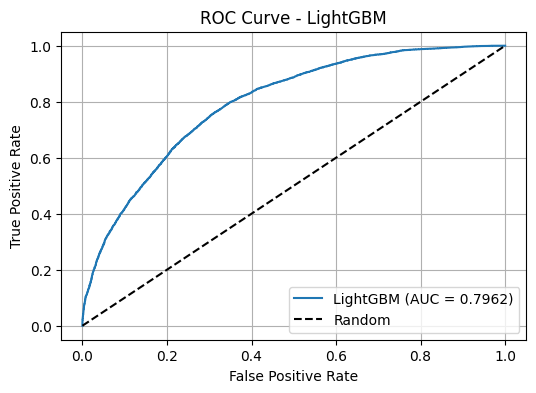

In [82]:
# LightGBM


# Extract the trained model

model = model_results['LightGBM']['model']

# Make the predictions

y_pred = model.predict(X_test)

# Predict the probabilities

y_proba = model.predict_proba(X_test)[:, 1]


# Clasification Report

print("Clasification Report:\n")
print(classification_report(y_test, y_pred))


# Confusion Matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'viridis')
plt.title('Confusion Matriz - LightGBM')
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.show()


# AUC - ROC Curve

auc = roc_auc_score(y_test, y_proba)
print("ROC AUC Score: ", auc)

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize = (6, 4))
plt.plot(fpr, tpr, label = f'LightGBM (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label = 'Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LightGBM')
plt.legend()
plt.grid()
plt.show()

# Model 2: XGBoost

Clasification Report:

              precision    recall  f1-score   support

           0       0.78      0.74      0.76     13071
           1       0.65      0.70      0.67      9214

    accuracy                           0.72     22285
   macro avg       0.71      0.72      0.71     22285
weighted avg       0.72      0.72      0.72     22285



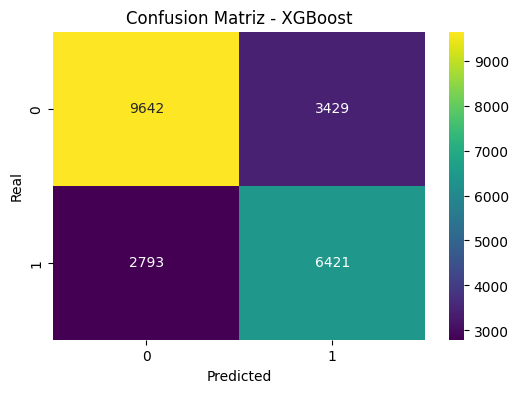

ROC AUC Score:  0.7939745090250859


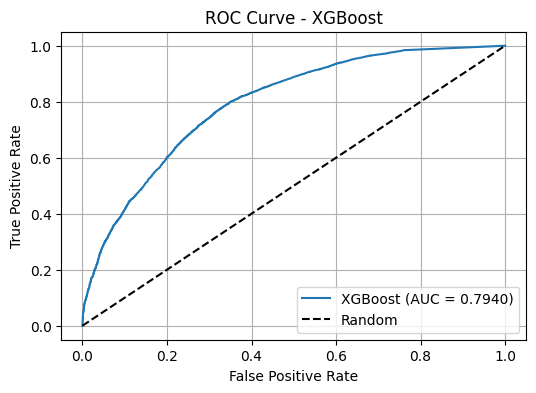

In [83]:
# XGBoost


# Extract the trained model

model = model_results['XGBoost']['model']

# Make the predictions

y_pred = model.predict(X_test)

# Predict the probabilities

y_proba = model.predict_proba(X_test)[:, 1]


# Clasification Report

print("Clasification Report:\n")
print(classification_report(y_test, y_pred))


# Confusion Matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'viridis')
plt.title('Confusion Matriz - XGBoost')
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.show()


# AUC - ROC Curve

auc = roc_auc_score(y_test, y_proba)
print("ROC AUC Score: ", auc)

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize = (6, 4))
plt.plot(fpr, tpr, label = f'XGBoost (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label = 'Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend()
plt.grid()
plt.show()

# Model 3: Stacking

Clasification Report:

              precision    recall  f1-score   support

           0       0.78      0.73      0.75     13071
           1       0.65      0.71      0.68      9214

    accuracy                           0.72     22285
   macro avg       0.71      0.72      0.71     22285
weighted avg       0.73      0.72      0.72     22285



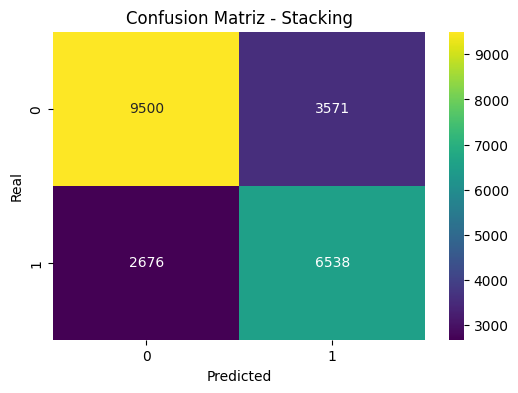

ROC AUC Score:  0.7957724942719462


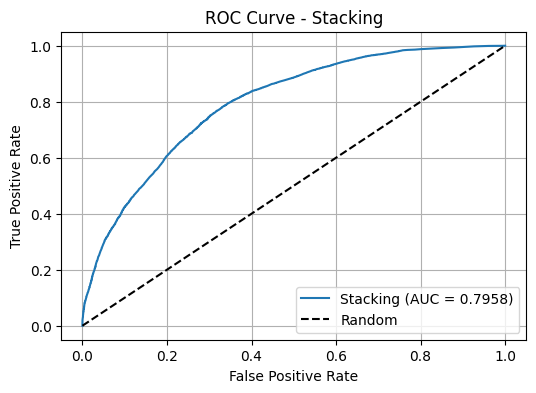

In [84]:
# Stacking


# Extract the trained model

model = model_results['Stacking']['model']

# Make the predictions

y_pred = model.predict(X_test)

# Predict the probabilities

y_proba = model.predict_proba(X_test)[:, 1]


# Clasification Report

print("Clasification Report:\n")
print(classification_report(y_test, y_pred))


# Confusion Matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'viridis')
plt.title('Confusion Matriz - Stacking')
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.show()


# AUC - ROC Curve

auc = roc_auc_score(y_test, y_proba)
print("ROC AUC Score: ", auc)

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize = (6, 4))
plt.plot(fpr, tpr, label = f'Stacking (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label = 'Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Stacking')
plt.legend()
plt.grid()
plt.show()

# Model 4: Random Forest

Clasification Report:

              precision    recall  f1-score   support

           0       0.76      0.76      0.76     13071
           1       0.66      0.65      0.66      9214

    accuracy                           0.72     22285
   macro avg       0.71      0.71      0.71     22285
weighted avg       0.72      0.72      0.72     22285



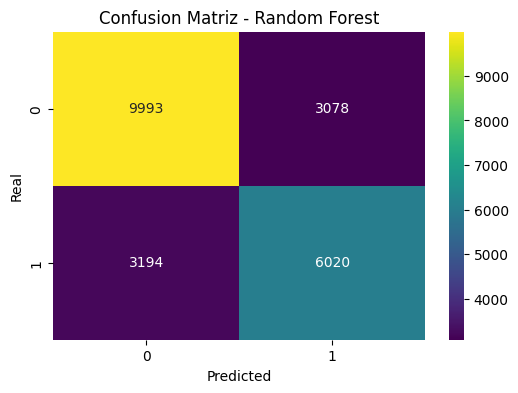

ROC AUC Score:  0.7917599588044105


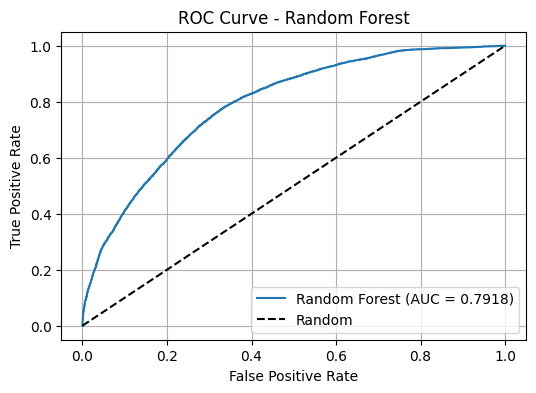

In [85]:
# Random Forest


# Extract the trained model

model = model_results['Random Forest']['model']

# Make the predictions

y_pred = model.predict(X_test)

# Predict the probabilities

y_proba = model.predict_proba(X_test)[:, 1]


# Clasification Report

print("Clasification Report:\n")
print(classification_report(y_test, y_pred))


# Confusion Matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'viridis')
plt.title('Confusion Matriz - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.show()


# AUC - ROC Curve

auc = roc_auc_score(y_test, y_proba)
print("ROC AUC Score: ", auc)

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize = (6, 4))
plt.plot(fpr, tpr, label = f'Random Forest (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label = 'Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend()
plt.grid()
plt.show()

# Model 5: KNN

Clasification Report:

              precision    recall  f1-score   support

           0       0.66      0.84      0.74     13071
           1       0.63      0.39      0.48      9214

    accuracy                           0.65     22285
   macro avg       0.65      0.62      0.61     22285
weighted avg       0.65      0.65      0.63     22285



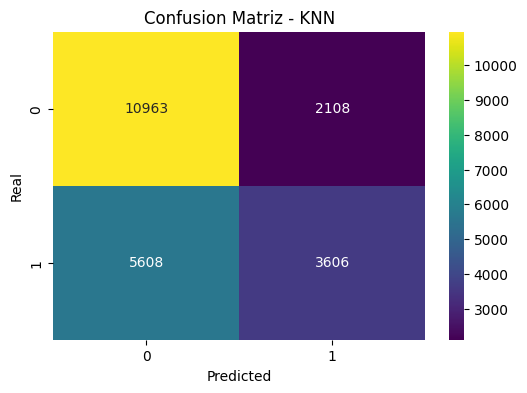

ROC AUC Score:  0.6993855684280424


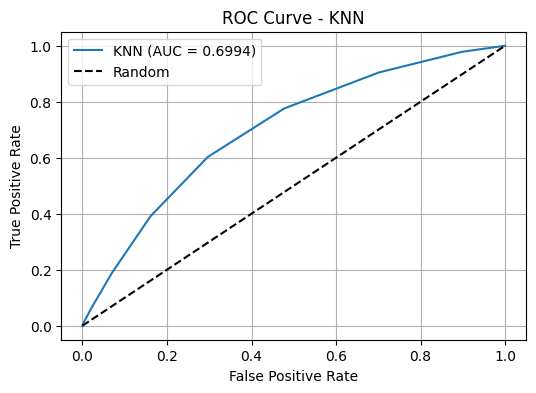

In [86]:
# KNN


# Extract the trained model

model = model_results['KNN']['model']

# Make the predictions

y_pred = model.predict(X_test)

# Predict the probabilities

y_proba = model.predict_proba(X_test)[:, 1]


# Clasification Report

print("Clasification Report:\n")
print(classification_report(y_test, y_pred))


# Confusion Matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'viridis')
plt.title('Confusion Matriz - KNN')
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.show()


# AUC - ROC Curve

auc = roc_auc_score(y_test, y_proba)
print("ROC AUC Score: ", auc)

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize = (6, 4))
plt.plot(fpr, tpr, label = f'KNN (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label = 'Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - KNN')
plt.legend()
plt.grid()
plt.show()

# Model 6: Decision Tree

Clasification Report:

              precision    recall  f1-score   support

           0       0.78      0.72      0.75     13071
           1       0.64      0.72      0.68      9214

    accuracy                           0.72     22285
   macro avg       0.71      0.72      0.72     22285
weighted avg       0.73      0.72      0.72     22285



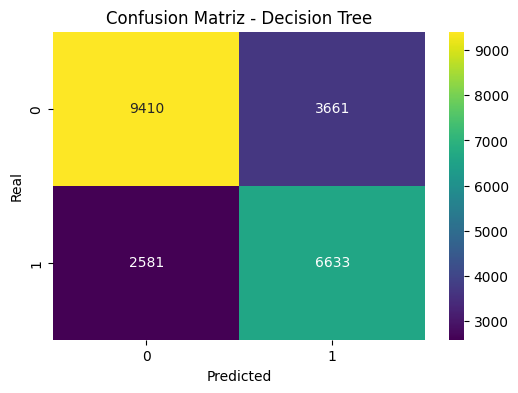

ROC AUC Score:  0.7762334136862545


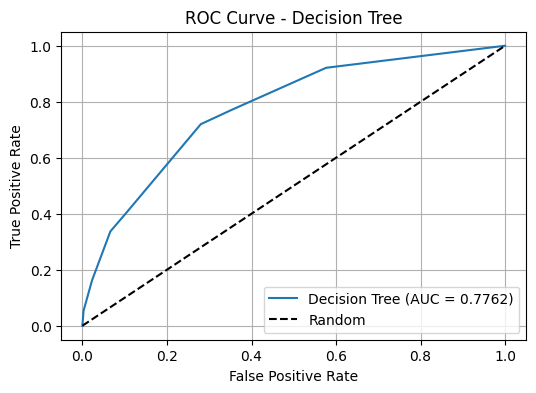

In [87]:
# Decision Tree


# Extract the trained model

model = model_results['Decision Tree']['model']

# Make the predictions

y_pred = model.predict(X_test)

# Predict the probabilities

y_proba = model.predict_proba(X_test)[:, 1]


# Clasification Report

print("Clasification Report:\n")
print(classification_report(y_test, y_pred))


# Confusion Matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'viridis')
plt.title('Confusion Matriz - Decision Tree')
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.show()


# AUC - ROC Curve

auc = roc_auc_score(y_test, y_proba)
print("ROC AUC Score: ", auc)

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize = (6, 4))
plt.plot(fpr, tpr, label = f'Decision Tree (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label = 'Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree')
plt.legend()
plt.grid()
plt.show()

# Model 7: Neuronal Network (MLP)

Clasification Report:

              precision    recall  f1-score   support

           0       0.76      0.74      0.75     13071
           1       0.65      0.67      0.66      9214

    accuracy                           0.72     22285
   macro avg       0.71      0.71      0.71     22285
weighted avg       0.72      0.72      0.72     22285



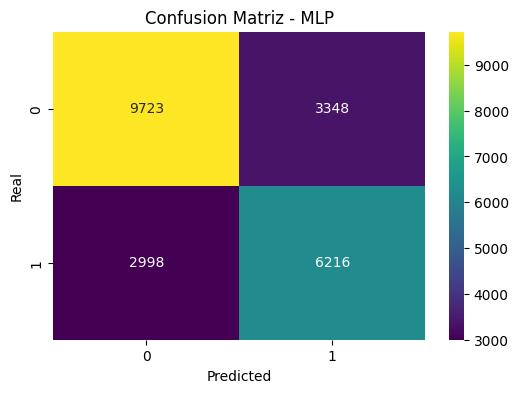

ROC AUC Score:  0.7864428321273587


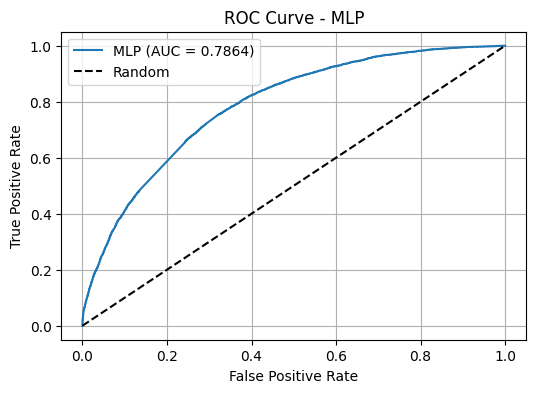

In [88]:
# MLP


# Extract the trained model

model = model_results['MLP']['model']

# Make the predictions

y_pred = model.predict(X_test)

# Predict the probabilities

y_proba = model.predict_proba(X_test)[:, 1]


# Clasification Report

print("Clasification Report:\n")
print(classification_report(y_test, y_pred))


# Confusion Matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'viridis')
plt.title('Confusion Matriz - MLP')
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.show()


# AUC - ROC Curve

auc = roc_auc_score(y_test, y_proba)
print("ROC AUC Score: ", auc)

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize = (6, 4))
plt.plot(fpr, tpr, label = f'MLP (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label = 'Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - MLP')
plt.legend()
plt.grid()
plt.show()

# Model 8: Gradient Boosting

Clasification Report:

              precision    recall  f1-score   support

           0       0.78      0.72      0.75     13071
           1       0.64      0.72      0.68      9214

    accuracy                           0.72     22285
   macro avg       0.71      0.72      0.72     22285
weighted avg       0.73      0.72      0.72     22285



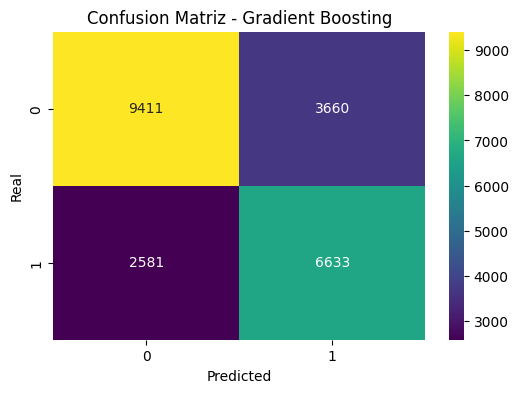

ROC AUC Score:  0.7927180055191715


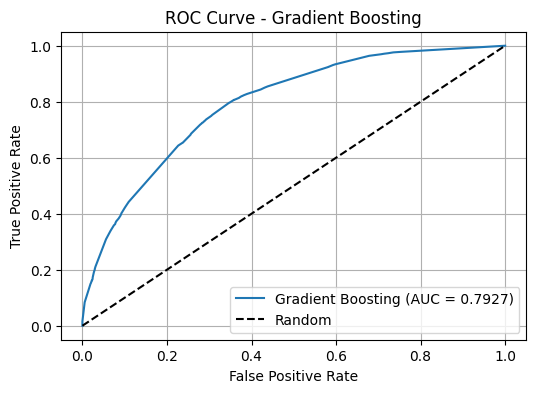

In [89]:
# Gradient Boosting


# Extract the trained model

model = model_results['Gradient Boosting']['model']

# Make the predictions

y_pred = model.predict(X_test)

# Predict the probabilities

y_proba = model.predict_proba(X_test)[:, 1]


# Clasification Report

print("Clasification Report:\n")
print(classification_report(y_test, y_pred))


# Confusion Matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'viridis')
plt.title('Confusion Matriz - Gradient Boosting')
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.show()


# AUC - ROC Curve

auc = roc_auc_score(y_test, y_proba)
print("ROC AUC Score: ", auc)

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize = (6, 4))
plt.plot(fpr, tpr, label = f'Gradient Boosting (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label = 'Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Gradient Boosting')
plt.legend()
plt.grid()
plt.show()